# Intro

In [3]:
# Import dependencies
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
from keras.models import Sequential, load_model, Model
from keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Dropout,
    BatchNormalization,
    Flatten,
    Input,
)
from sklearn.model_selection import train_test_split

# Data loading

In [43]:
# Declare dataset path
dataset_folder = "CK+48 dataset"
sub_folders = os.listdir(dataset_folder)

# Initialize variables
images = []
labels = []
i = 0
last = []

# Create a mapping for folder names to labels
emotion_mapping = {emotion: idx for idx, emotion in enumerate(sub_folders)}

# Read folders in the main dataset folder, one at a time
for sub_folder in sub_folders:
    label = emotion_mapping[sub_folder]  # Unique label for each emotion class

    path = dataset_folder + "/" + sub_folder
    sub_folder_images = os.listdir(path)

    # Read images in the sub-folder, one at a time
    for image in sub_folder_images:
        image_path = path + "/" + image
        print(image_path + "\t" + str(label))

        # Preprocess the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (48, 48))
        images.append(image)
        labels.append(label)
        i += 1
    last.append(i)

# Convert lists to arrays
images_x = np.array(images)
labels_y = np.array(labels)

# Normalize image pixel values
images_x = images_x / 255.0

# One-hot encode the labels
num_of_classes = len(sub_folders)  # Total number of unique classes
labels_y_encoded = tf.keras.utils.to_categorical(labels_y, num_classes=num_of_classes)

# Split into 75:25 train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    images_x,
    labels_y_encoded,
    test_size=0.25,
    random_state=10,
    stratify=labels_y_encoded,
)

/content/drive/MyDrive/Proyecto de Ingenieria de Datos/Alternative model regular CNN/CK+48 dataset/surprise/S078_001_00000031.png	0
/content/drive/MyDrive/Proyecto de Ingenieria de Datos/Alternative model regular CNN/CK+48 dataset/surprise/S076_001_00000017.png	0
/content/drive/MyDrive/Proyecto de Ingenieria de Datos/Alternative model regular CNN/CK+48 dataset/surprise/S075_002_00000012.png	0
/content/drive/MyDrive/Proyecto de Ingenieria de Datos/Alternative model regular CNN/CK+48 dataset/surprise/S077_001_00000026.png	0
/content/drive/MyDrive/Proyecto de Ingenieria de Datos/Alternative model regular CNN/CK+48 dataset/surprise/S071_001_00000012.png	0
/content/drive/MyDrive/Proyecto de Ingenieria de Datos/Alternative model regular CNN/CK+48 dataset/surprise/S073_001_00000012.png	0
/content/drive/MyDrive/Proyecto de Ingenieria de Datos/Alternative model regular CNN/CK+48 dataset/surprise/S074_002_00000014.png	0
/content/drive/MyDrive/Proyecto de Ingenieria de Datos/Alternative model reg

In [44]:
print(X_train.shape[0])

import numpy as np

# Count occurrences for Y_train and Y_test, assuming one-hot encoding
y_train_labels = np.argmax(Y_train, axis=1) if Y_train.ndim > 1 else Y_train
y_test_labels = np.argmax(Y_test, axis=1) if Y_test.ndim > 1 else Y_test

# Print class counts for Y_train
print("Train Set Class Counts:")
for i, count in enumerate(np.bincount(y_train_labels)):
    print(f"Class {i}: {count} samples")

# Print class counts for Y_test
print("\nTest Set Class Counts:")
for i, count in enumerate(np.bincount(y_test_labels)):
    print(f"Class {i}: {count} samples")

291
Train Set Class Counts:
Class 0: 44 samples
Class 1: 40 samples
Class 2: 44 samples
Class 3: 40 samples
Class 4: 44 samples
Class 5: 39 samples
Class 6: 40 samples

Test Set Class Counts:
Class 0: 15 samples
Class 1: 14 samples
Class 2: 15 samples
Class 3: 13 samples
Class 4: 15 samples
Class 5: 13 samples
Class 6: 13 samples


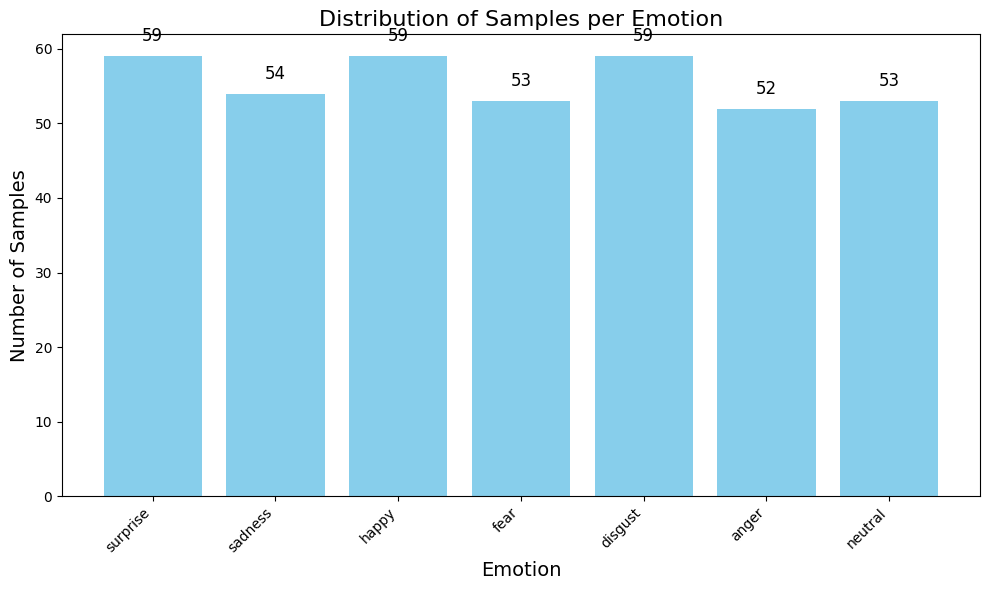

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of samples per class
unique_classes, counts = np.unique(labels, return_counts=True)

# Map class indices to emotion names
class_names = {
    v: k for k, v in emotion_mapping.items()
}  # Reverse the mapping for easy lookup
emotion_names = [class_names[class_id] for class_id in unique_classes]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(emotion_names, counts, color="skyblue")

# Add labels and title
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.title("Distribution of Samples per Emotion", fontsize=16)

# Add count values above bars
for i, count in enumerate(counts):
    plt.text(i, count + 2, str(count), ha="center", fontsize=12)

# Show the plot
plt.xticks(rotation=45, ha="right")  # Rotate emotion names for better readability
plt.tight_layout()
plt.show()

#Model and training

In [46]:
# CNN Architecture
input = Input(shape=(48, 48, 1))
conv1 = Conv2D(
    32, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation("relu")(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(
    64, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation("relu")(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(
    128, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation("relu")(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(
    256, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation("relu")(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
flatten = Flatten()(pool4)
dense_1 = Dense(128, activation="relu")(flatten)
drop_1 = Dropout(0.2)(dense_1)
output = Dense(num_of_classes, activation="softmax")(drop_1)

# Model compile
model = Model(inputs=input, outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=["accuracy"])
model.summary()

# Configure Model Checkpoint
fle_s = "./output/emotion_model.h5"
checkpointer = ModelCheckpoint(
    fle_s,
    monitor="loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
callback_list = [checkpointer]


save = model.fit(
    X_train,
    Y_train,
    batch_size=10,
    validation_data=(X_test, Y_test),
    epochs=30,
    callbacks=[callback_list],
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 dropout_25 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 activation_20 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 64)        18496     
                                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - ETA: 0s - loss: 2.0657 - accuracy: 0.1615
Epoch 2: loss improved from 2.17694 to 2.06575, saving model to ./output/emotion_model.h5
30/30 [==============================] - 3s 95ms/step - loss: 2.0657 - accuracy: 0.1615 - val_loss: 2.0356 - val_accuracy: 0.1837
Epoch 3/30
29/30 [============================>.] - ETA: 0s - loss: 2.0219 - accuracy: 0.1655
Epoch 3: loss improved from 2.06575 to 2.02201, saving model to ./output/emotion_model.h5
30/30 [==============================] - 3s 92ms/step - loss: 2.0220 - accuracy: 0.1649 - val_loss: 2.0054 - val_accuracy: 0.1531
Epoch 4/30
29/30 [============================>.] - ETA: 0s - loss: 1.9894 - accuracy: 0.1931
Epoch 4: loss improved from 2.02201 to 1.98927, saving model to ./output/emotion_model.h5
30/30 [==============================] - 3s 95ms/step - loss: 1.9893 - accuracy: 0.1959 - val_loss: 1.9865 - val_accuracy: 0.2143
Epoch 5/30
29/30 [============================>.] - ETA: 0s - loss: 1

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

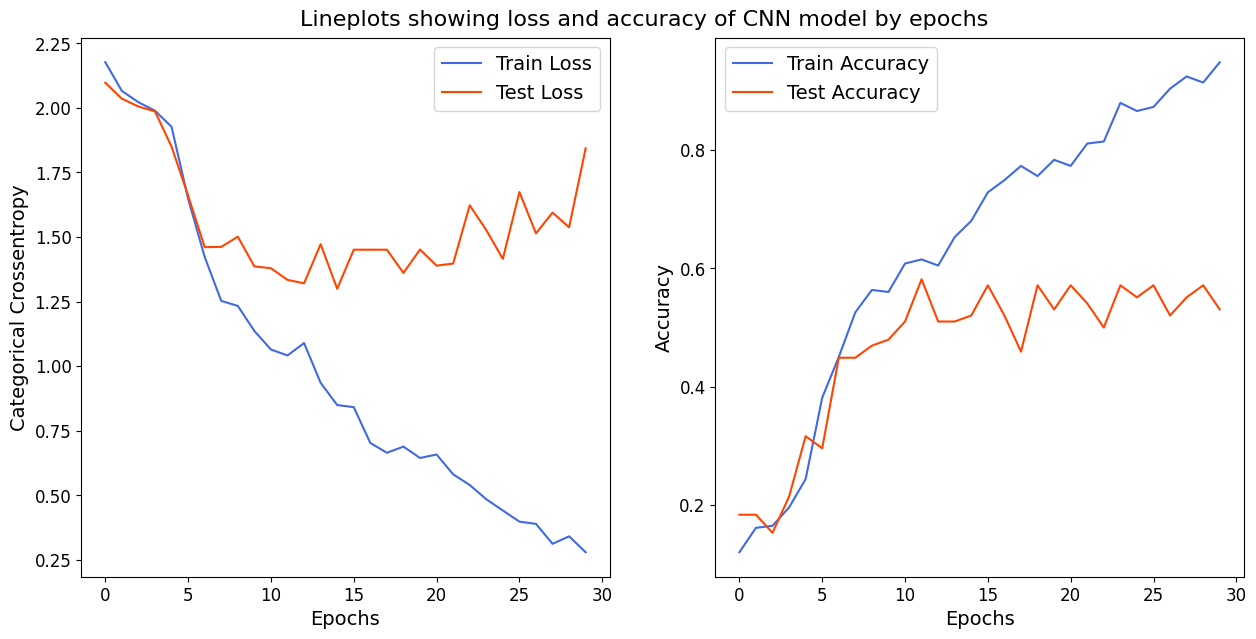

In [49]:
# Checking the train and test loss and accuracy values from the neural network above.
train_loss = save.history["loss"]
test_loss = save.history["val_loss"]
train_accuracy = save.history["accuracy"]
test_accuracy = save.history["val_accuracy"]

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax = ax.ravel()
ax[0].plot(train_loss, label="Train Loss", color="royalblue")
ax[0].plot(test_loss, label="Test Loss", color="orangered")
ax[0].set_xlabel("Epochs", fontsize=14)
ax[0].set_ylabel("Categorical Crossentropy", fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis="both", labelsize=12)
ax[1].plot(train_accuracy, label="Train Accuracy", color="royalblue")
ax[1].plot(test_accuracy, label="Test Accuracy", color="orangered")
ax[1].set_xlabel("Epochs", fontsize=14)
ax[1].set_ylabel("Accuracy", fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis="both", labelsize=12)
fig.suptitle(
    x=0.5,
    y=0.92,
    t="Lineplots showing loss and accuracy of CNN model by epochs",
    fontsize=16,
)

# Validation

4/4 [==============================] - 0s 37ms/step


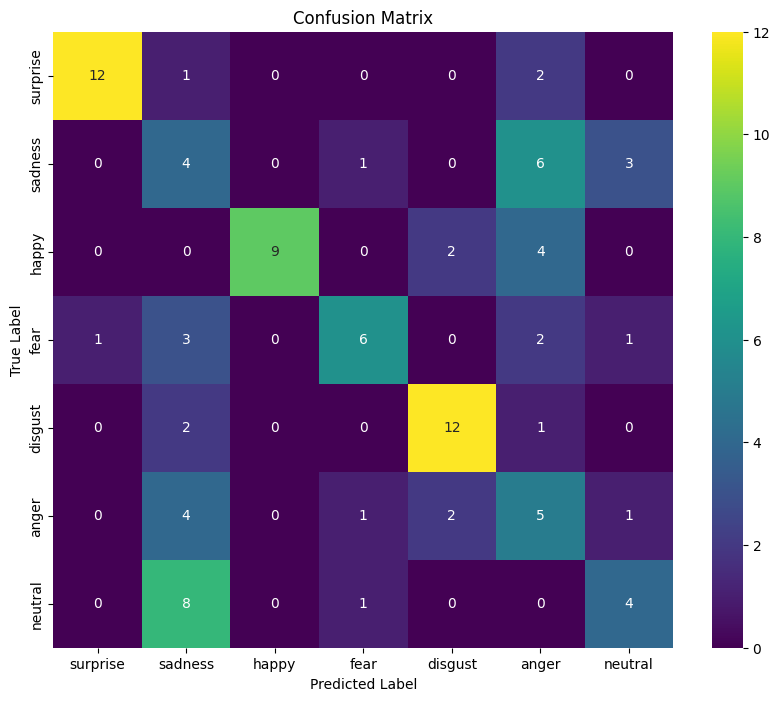

Classification Report:
              precision    recall  f1-score   support

    surprise       0.92      0.80      0.86        15
     sadness       0.18      0.29      0.22        14
       happy       1.00      0.60      0.75        15
        fear       0.67      0.46      0.55        13
     disgust       0.75      0.80      0.77        15
       anger       0.25      0.38      0.30        13
     neutral       0.44      0.31      0.36        13

    accuracy                           0.53        98
   macro avg       0.60      0.52      0.55        98
weighted avg       0.62      0.53      0.56        98

Accuracy: 0.5306
Macro Precision: 0.6023
Macro Recall: 0.5199
Macro F1-Score: 0.5451
Weighted Precision: 0.6157
Weighted Recall: 0.5306
Weighted F1-Score: 0.5570


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
import seaborn as sns


# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, cmap="viridis"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


# Function to compute metrics
def evaluate_model(y_true, y_pred, class_names):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1-score (macro and weighted averages)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print(f"Macro F1-Score: {f1:.4f}")

    precision_weighted = precision_score(y_true, y_pred, average="weighted")
    recall_weighted = recall_score(y_true, y_pred, average="weighted")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall: {recall_weighted:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")


# Assuming the model is already trained and tested
# Example predictions
# y_true: True labels of the test set
# y_pred: Predicted labels from the model
# class_names: List of class names corresponding to labels
y_pred = model.predict(X_test)  # Predict probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(Y_test, axis=1)  # True labels in class form

# Define class names (replace these with your actual class names)
class_names = sub_folders

# Plot confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes, class_names, cmap="viridis")

# Evaluate the model
evaluate_model(y_true_classes, y_pred_classes, class_names)

# Other models

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2  # Make sure to import cv2 if you're using it


# Load and preprocess the data
def preprocess_data(images, labels, img_size=(224, 224)):
    # Resize images
    images_resized = np.array([cv2.resize(img, img_size) for img in images])

    # Ensure images are 3-channel (RGB), even if they are grayscale
    if images_resized.ndim == 3:  # Grayscale to RGB
        images_resized = np.stack([images_resized] * 3, axis=-1)

    # Normalize pixel values
    images_normalized = images_resized / 255.0
    return images_normalized, tf.keras.utils.to_categorical(labels, num_classes=7)


X_train, X_test, Y_train, Y_test = train_test_split(
    images_x, labels_y, test_size=0.25, random_state=42
)
X_train, Y_train = preprocess_data(X_train, Y_train)
X_test, Y_test = preprocess_data(X_test, Y_test)

# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)


# Define a function to build models
def build_model(base_model, num_classes=7):
    base_model.trainable = False  # Freeze the base model
    inputs = tf.keras.Input(
        shape=(224, 224, 3)
    )  # Ensure the model expects 3-channel images
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)
    return model


# List of pre-trained models to test
pretrained_models = {
    "VGG16": VGG16(weights="imagenet", include_top=False),
    "ResNet50": ResNet50(weights="imagenet", include_top=False),
    "EfficientNetB0": EfficientNetB0(weights="imagenet", include_top=False),
}

results = {}

# Loop through each model
for model_name, base_model in pretrained_models.items():
    print(f"\nTraining with {model_name}...")
    model = build_model(base_model, num_classes=7)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # Train the model
    history = model.fit(
        data_gen.flow(X_train, Y_train, batch_size=16),
        validation_data=(X_test, Y_test),
        epochs=20,
        verbose=1,
    )

    # Evaluate and save results
    _, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
    results[model_name] = test_accuracy
    print(f"{model_name} Accuracy: {test_accuracy:.4f}")

# Find and print the best model
best_model_name = max(results, key=results.get)
print("\nBest Model:", best_model_name, "with accuracy:", results[best_model_name])


Training with VGG16...
Epoch 1/20
19/19 [==============================] - 92s 5s/step - loss: 2.1020 - accuracy: 0.1409 - val_loss: 2.0128 - val_accuracy: 0.1122
Epoch 2/20
19/19 [==============================] - 90s 5s/step - loss: 1.9971 - accuracy: 0.1237 - val_loss: 1.9705 - val_accuracy: 0.1122
Epoch 3/20
19/19 [==============================] - 91s 5s/step - loss: 2.0053 - accuracy: 0.1375 - val_loss: 1.9568 - val_accuracy: 0.1122
Epoch 4/20
19/19 [==============================] - 92s 5s/step - loss: 1.9831 - accuracy: 0.1512 - val_loss: 1.9502 - val_accuracy: 0.1837
Epoch 5/20
15/19 [======================>.......] - ETA: 14s - loss: 2.0169 - accuracy: 0.1057

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf

# Get the best model's predictions
best_model = build_model(pretrained_models[best_model_name], num_classes=7)
best_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

# Train the model (if not already trained)
best_model.fit(
    data_gen.flow(X_train, Y_train, batch_size=16),
    validation_data=(X_test, Y_test),
    epochs=20,
    verbose=1,
)

# Predict on the test set
Y_pred = best_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert predictions to class labels
Y_true = np.argmax(Y_test, axis=1)  # Convert true labels to class labels

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=np.arange(7),
    yticklabels=np.arange(7),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix of {best_model_name}")
plt.show()

# Classification Report (Accuracy, Precision, Recall, F1-score)
report = classification_report(
    Y_true, Y_pred_classes, target_names=[f"Class {i}" for i in range(7)]
)
print("Classification Report:\n", report)